In [3]:
import pandas as pd
import os
import os.path as osp
import matplotlib.pyplot as plt
from google.transit import gtfs_realtime_pb2
from datetime import datetime

In [2]:
path = 'static_gtfs'
routes = pd.read_csv(osp.join(path,'routes.txt'),sep=',', low_memory=False)
shapes = pd.read_csv(osp.join(path,'shapes.txt'),sep=',', low_memory=False)
stop_times = pd.read_csv(osp.join(path,'stop_times.txt'),sep=',', low_memory=False)
stops = pd.read_csv(osp.join(path,'stops.txt'),sep=',', low_memory=False)
trips = pd.read_csv(osp.join(path,'trips.txt'),sep=',', low_memory=False)

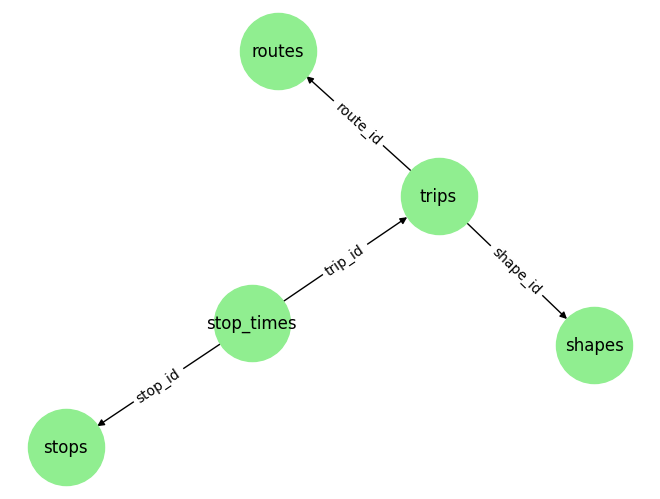

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Tables
tables = ['routes', 'trips', 'stop_times', 'stops', 'shapes']

# Graph
G = nx.DiGraph()
G.add_nodes_from(tables)

# Edges based on foreign key relationships
G.add_edge('trips', 'routes', label='route_id')
G.add_edge('stop_times', 'trips', label='trip_id')
G.add_edge('stop_times', 'stops', label='stop_id')
G.add_edge('trips', 'shapes', label='shape_id')

# Draw
pos = nx.spring_layout(G, seed=42)  # consistent layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightgreen')
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [11]:
bus_routes = routes[routes['route_type'] == 3]
bus_trips = trips[trips['route_id'].isin(bus_routes['route_id'])]
bus_stop_times = stop_times[stop_times['trip_id'].isin(bus_trips['trip_id'])]
bus_stops = stops[stops['stop_id'].isin(bus_stop_times['stop_id'])]
bus_shapes = shapes[shapes['shape_id'].isin(bus_trips['shape_id'].dropna())]

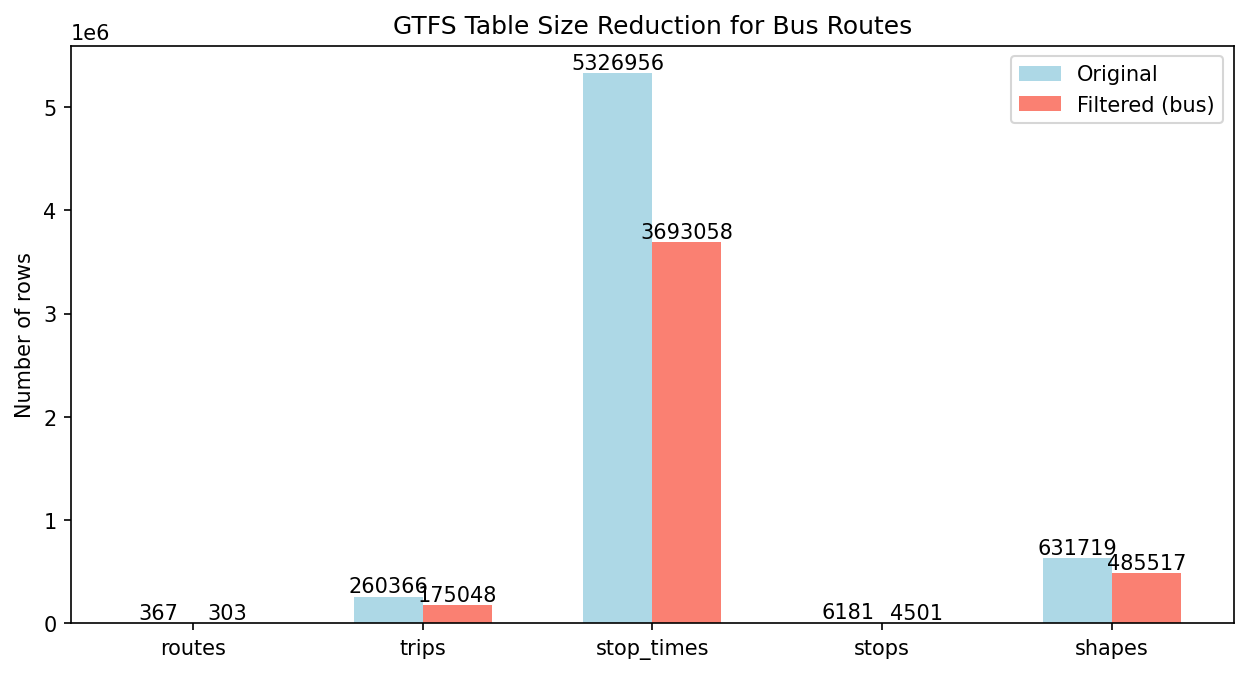

In [16]:
# Original counts
original_counts = {
    'routes': len(routes),
    'trips': len(trips),
    'stop_times': len(stop_times),
    'stops': len(stops),
    'shapes': len(shapes)
}

# Filtered counts
filtered_counts = {
    'routes': len(bus_routes),
    'trips': len(bus_trips),
    'stop_times': len(bus_stop_times),
    'stops': len(bus_stops),
    'shapes': len(bus_shapes)
}


labels = original_counts.keys()
x = range(len(labels))
plt.figure(figsize=(10,5),dpi=150)

# Original bars
orig_bars = plt.bar([i-0.15 for i in x], original_counts.values(), width=0.3, label='Original', color='lightblue')
# Filtered bars
filt_bars = plt.bar([i+0.15 for i in x], filtered_counts.values(), width=0.3, label='Filtered (bus)', color='salmon')

# Add numbers above bars
for bar in orig_bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom')
for bar in filt_bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom')

plt.xticks(x, labels)
plt.ylabel('Number of rows')
plt.title('GTFS Table Size Reduction for Bus Routes')
plt.legend()
plt.show()


In [17]:
display(bus_routes.head(2))
display(bus_shapes.head(2))
display(bus_stop_times.head(2))
display(bus_stops.head(2))
display(bus_trips.head(2))

,agency_id,route_id,route_short_name,route_long_name,route_type,route_desc,route_color,route_text_color,route_sort_order
0,BKK,0050,5,NaN,3,"Pasaréti tér / Rákospalota, Kossuth utca",009EE3,FFFFFF,20
1,BKK,0070,7,NaN,3,"Albertfalva vasútállomás / Újpalota, Nyírpalot...",009EE3,FFFFFF,23


,shape_id,shape_pt_sequence,shape_pt_lat,shape_pt_lon,shape_dist_traveled
7019,1135,429505,47.559437,19.006721,0.0
7020,1135,429506,47.559473,19.006721,4.0


,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
12966,C564032,F03289,00:27:00,00:27:00,0,"Kispest, Kossuth tér",NaN,1.0,0.0
12967,C564032,F03450,00:28:00,00:28:00,1,"Kispest, Kossuth tér",NaN,NaN,536.0


,stop_id,stop_name,stop_lat,stop_lon,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding
11,007817,Márta utca,47.429184,18.929497,007817,NaN,NaN,NaN,2.0
12,007877,Bíróság,47.519544,18.978060,007877,NaN,NaN,NaN,1.0


,route_id,trip_id,service_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
1202,9680,C564032,C56403ASZCsZ-011,"Kispest, Kossuth tér",1,C56403_0680_3_0,AV91,1.0,2.0
1203,9680,C564033,C56403ASZCsZ-011,Cinkotai autóbuszgarázs,0,C56403_0680_3_1,AV90,1.0,2.0


In [4]:
class DynamicGTFS:
    def __init__(self,folder='dynamic_gtfs/trials/try_003',name='feed_20251013_221949'):
        feed = gtfs_realtime_pb2.FeedMessage()
        with open(osp.join(folder,f'{name}.pb'), "rb") as f:
            feed.ParseFromString(f.read())

        self.timestamp = feed.header.timestamp
        self.vehicles = feed.entity

In [5]:
dyn = DynamicGTFS()
dyn.vehicles[1]

id: "VehiclePosition-BKK_1017"
vehicle {
  trip {
    trip_id: "C889321280"
    start_date: "20251013"
    schedule_relationship: SCHEDULED
    route_id: "0680"
  }
  position {
    latitude: 47.4410286
    longitude: 19.1382103
    bearing: 136
    speed: 9.25999165
  }
  current_stop_sequence: 28
  current_status: IN_TRANSIT_TO
  timestamp: 1760386787
  stop_id: "F03986"
  vehicle {
    id: "1017"
    label: "Kispest, Vas Gereben utca"
    license_plate: "BPO236"
  }
}

In [33]:
class StaticGTFS:
    def __init__(self,path='static_gtfs'):
            self.routes = None
            self.shapes = None
            self.stop_times = None
            self.stops = None
            self.trips = None
    
    def plot_map(self,ax,c='black'):
        ax.scatter(self.stops['stop_lon'], self.stops['stop_lat'], s=5, c=c, alpha=0.7)
        for _, group in self.shapes.groupby("shape_id"):
            group = group.sort_values("shape_pt_sequence")
            ax.plot(group["shape_pt_lon"], group["shape_pt_lat"], linewidth=0.5, c=c)
        ax.set_aspect('equal')

    def plot_shape(self,ax,shape_id,c):
        shape = shapes[shapes["shape_id"] == shape_id].sort_values("shape_pt_sequence")
        ax.plot(shape["shape_pt_lon"], shape["shape_pt_lat"], linewidth=0.5, c=c)
    
    def plot_stops(self,ax,stop_ids,c):
        stops = self.stops[self.stops["stop_id"].isin(stop_ids)]
        ax.scatter(stops["stop_lon"], stops["stop_lat"], c=c, s=5, alpha=0.7)

    def plot_trip(self,ax,trip_id,c):
        self.plot_stops(ax,self.stop_ids_of_trip(trip_id),c)
        self.plot_shape(ax,self.shape_id_of_trip(trip_id),c)

    def stop_ids_of_trip(self,trip_id:str) -> list[str]:
        return self.stops_of_trip(trip_id)['stop_id'].tolist()
    
    def shape_id_of_trip(self,trip_id:str) -> str:
        return trips[trips['trip_id'] == trip_id]['shape_id'].iloc[0]


    def where_is(self, vehicle):
        if vehicle.vehicle.trip.trip_id:
            trip_id = vehicle.vehicle.trip.trip_id
            current_stop_seq = vehicle.vehicle.current_stop_sequence
            timestamp = vehicle.vehicle.timestamp  # vehicle timestamp (epoch)
            time_str = datetime.fromtimestamp(timestamp).strftime("%H:%M:%S")


            # Get stops of the trip sorted by sequence
            stops_of_trip = self.stops_of_trip(trip_id)
            
            if current_stop_seq == 0:
                # Vehicle has not reached first stop yet
                next_stop = stops_of_trip.iloc[0]
                print(f"Trip ID: {trip_id}")
                print(f"Current timestamp: {time_str}")
                print(f"Vehicle has not reached the first stop yet.")
                print(f"Next stop {next_stop.stop_id} scheduled arrival: {next_stop.arrival_time}")
            else:
                # Vehicle is between prev and next stop
                prev_stop = stops_of_trip[stops_of_trip['stop_sequence'] == current_stop_seq - 1].iloc[0]
                next_stop = stops_of_trip[stops_of_trip['stop_sequence'] == current_stop_seq].iloc[0]
                print(f"Trip ID: {trip_id}")
                print(f"Current timestamp: {time_str}")
                print(f"Vehicle is after stop {prev_stop.stop_id} and heading to stop {next_stop.stop_id}")
                print(f"Scheduled arrival times:")
                print(f"  Previous stop {prev_stop.stop_id}: {prev_stop.arrival_time}")
                print(f"  Next stop {next_stop.stop_id}: {next_stop.arrival_time}")

            

    def stops_of_trip(self,trip_id:str) -> pd.DataFrame:
        return stop_times[stop_times['trip_id'] == trip_id].sort_values('stop_sequence')


         

In [34]:
static = StaticGTFS()
static.routes = bus_routes
static.shapes = bus_shapes
static.stop_times = bus_stop_times
static.stops = bus_stops
static.trips = bus_trips

In [35]:
static.where_is(vehicle=dyn.vehicles[3])

Trip ID: D0477614487
Current timestamp: 22:19:45
Vehicle is after stop F01051 and heading to stop F01059
Scheduled arrival times:
  Previous stop F01051: 22:17:00
  Next stop F01059: 22:18:00


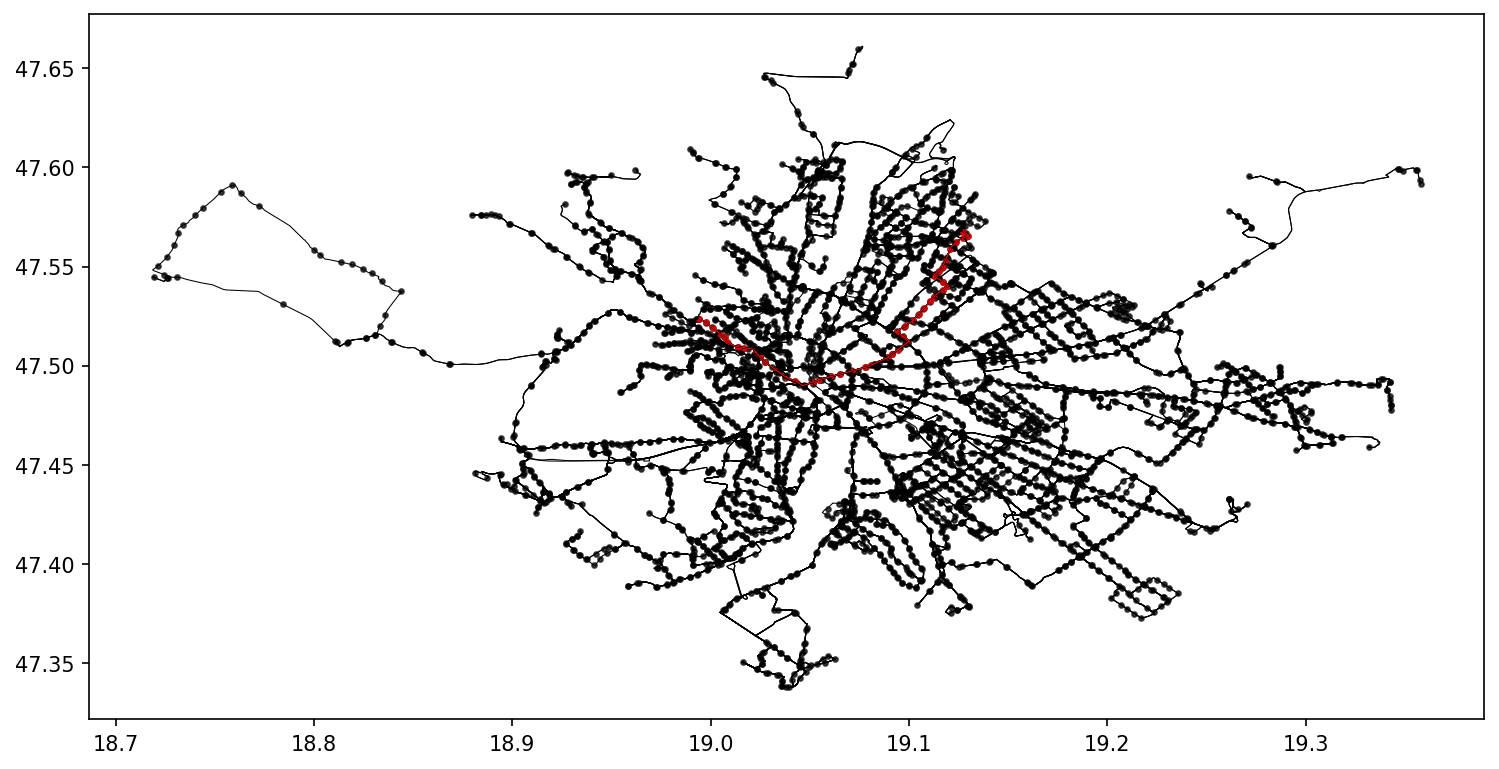

In [36]:
fig, ax = plt.subplots(1,figsize=(12,12),dpi=150)

static.plot_map(ax)
static.plot_trip(ax,'D0166810',c='red')